In [1]:
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [4]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2) #앞에 0포함, 단어는 999개

2110848/2110848 [==============================] - 0s 0us/step


In [17]:
X_train

array([[  0,   0,   0, ...,  15,  17,  12],
       [  0,   0,   0, ..., 505,  17,  12],
       [ 19, 758,  15, ...,  11,  17,  12],
       ...,
       [  0,   0,   0, ..., 407,  17,  12],
       [ 88,   2,  72, ..., 364,  17,  12],
       [125,   2,  21, ..., 113,  17,  12]])

In [5]:
category = np.max(y_train) + 1 #46개 중 하나의 카테고리를 맞추는 다중분류 모델
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
X_train = sequence.pad_sequences(X_train, maxlen=100) #padding
X_test = sequence.pad_sequences(X_test, maxlen=100)

In [7]:
y_train = to_categorical(y_train) #one-hot encoding
y_test = to_categorical(y_test)

In [14]:
model = models.Sequential()
model.add(layers.Embedding(1000, 100)) #embedding 100길이
#https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
model.add(layers.LSTM(100, activation='tanh', return_sequences=True)) #(200*100+ 100)* 4 #이전 출력 +100 #LSTM 여러개 연결하려면 cell state 정보도 넘겨줘야 함
#LSTM 여러개 연결 시 1층에 return_sequences=True #https://blog.naver.com/chunjein/221589695541
model.add(layers.LSTM(100, activation='tanh'))
model.add(layers.Dense(46, activation='softmax')) #100*26+26

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         100000    
                                                                 
 lstm_1 (LSTM)               (None, None, 100)         80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 46)                4646      
                                                                 
Total params: 265,446
Trainable params: 265,446
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/200
450/450 [==============================] - 19s 36ms/step - loss: 2.1935 - accuracy: 0.4421 - val_loss: 2.2809 - val_accuracy: 0.4964
Epoch 2/200
450/450 [==============================] - 16s 35ms/step - loss: 1.9421 - accuracy: 0.5145 - val_loss: 1.7495 - val_accuracy: 0.5730
Epoch 3/200
450/450 [==============================] - 16s 35ms/step - loss: 1.6894 - accuracy: 0.5685 - val_loss: 1.6787 - val_accuracy: 0.5748
Epoch 4/200
450/450 [==============================] - 16s 37ms/step - loss: 1.5802 - accuracy: 0.5974 - val_loss: 1.5644 - val_accuracy: 0.6131
Epoch 5/200
450/450 [==============================] - 16s 35ms/step - loss: 1.4159 - accuracy: 0.6455 - val_loss: 1.4184 - val_accuracy: 0.6541
Epoch 6/200
450/450 [==============================] - 15s 33ms/step - loss: 1.3045 - accuracy: 0.6721 - val_loss: 1.3793 - val_accuracy: 0.6518
Epoch 7/200
450/450 [==============================] - 16s 34ms/step - loss: 1.2011 - accuracy: 0.6952 - val_loss: 1.2965 - val_ac

In [12]:
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 12ms/step - loss: 1.1998 - accuracy: 0.7164

 Test Accuracy: 0.7164


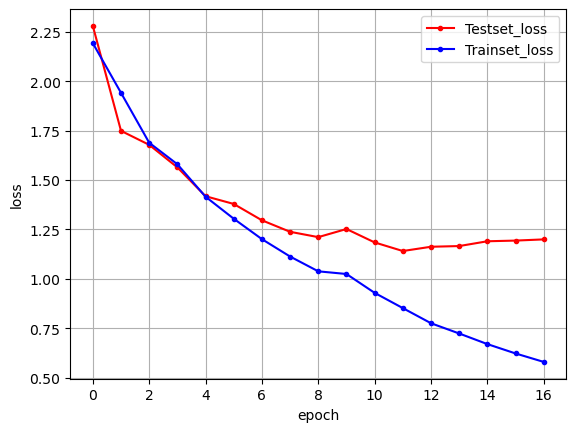

In [13]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다. 
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()